In [1]:
import pickle
with open("events.pkl","rb") as f:
    events = pickle.load(f)

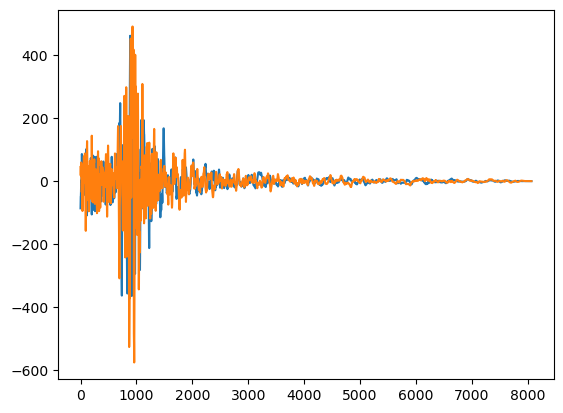

In [2]:
from Experimental_System_ID import create_model, analyze, get_inputs, get_outputs
import numpy as np
import matplotlib.pyplot as plt
from mdof.utilities.testing import truncate_by_bounds, intensity_bounds

input_channels = [1,3]
i = 19
inputs, dt = get_inputs(i, events, input_channels, scale=2.54)
inputs = truncate_by_bounds(inputs,intensity_bounds(inputs,lb=0.0025,ub=0.99))
plt.plot(inputs.T)
nt = inputs.shape[1]
model = create_model(column="forceBeamColumn",girder="forceBeamColumn",inputx=inputs[0],inputy=inputs[1],dt=dt)

In [3]:
disp = analyze(model, output_nodes=list(range(1,20)), nt=nt, dt=dt)

Analysis Progress (8063 timesteps)


100%|██████████| 8063/8063 [00:10<00:00, 765.27it/s]


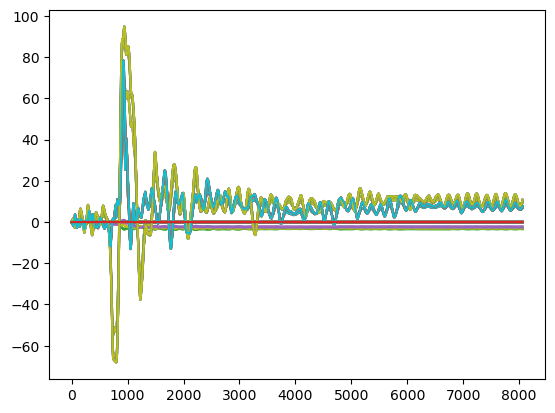

In [4]:
SCALE = 2
START_IND = 1
END_IND = 1

outputs = get_outputs(disp)
adjusted_disp = disp.copy()
for node,d in disp.items():
    adjusted_disp[node] = SCALE*np.array(d[START_IND:-END_IND])
    plt.plot(SCALE*np.array(d[START_IND:-END_IND]))

In [5]:
import veux, veux.motion
from xsection.library import Rectangle

In [6]:
def get_amplitude(node):
    return model.nodeEigenvector(node, 1)

In [7]:
n_modes=4

model.eigen('-fullBandLapack',n_modes)
# model.eigen(n_modes)

for mode in range(1,n_modes+1):
    # Create an artist to manage the canvas
    artist = veux.create_artist(model, vertical=3, model_config={
        "frame_shape": Rectangle(1,1),
        "frame_samples": 4
    })
    artist.draw_outlines(state=lambda node: model.nodeEigenvector(node, mode), scale=100)
    # artist.draw_outlines(state=get_amplitude)

    artist.save(f"mode_{mode}.glb")

eigen - unknown option: -fullBandLapack


/opt/homebrew/Caskroom/miniforge/base/envs/mdof-dev-brew/lib/python3.11/site-packages/veux/model.py:1006: UserWarning: Failed to compute alpha shape
  warnings.warn("Failed to compute alpha shape")


In [8]:
artist.draw_outlines()

# For each timestep, draw the new node positions and rotations
motion = veux.motion.Motion(artist)
for i in range(500):
    motion.draw_sections(position = lambda s: adjusted_disp[s][i][:3],
                         rotation = lambda s: [0,0,0,1])  # identity quaternion
    motion.advance(i*dt)

motion.add_to(artist.canvas)

# Free online viewer for .glb files: https://gltf-viewer.donmccurdy.com/
artist.save("model.glb")
artist

In [9]:
model.wipe()